In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.linalg import cho_factor, cho_solve
from data_utils import load_dataset 
import sys 

# Q1 (a). Laplace Approximation of Log Marginal Likelihood

In [2]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
y_train, y_test = np.vstack((y_train[:,(1,)], y_valid[:,(1,)])), y_test[:,(1,)]
x_train, x_test = np.vstack((x_train, x_valid)), x_test
x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

Define the calculation functions used during the training and log marginal likelihood computation process. The mathematical operations used for this sub question are described in more detail in the PDF report document under Q1(a).

In [3]:
def sigmoid(x, w):
    return 1 /(1 + np.exp(-np.dot(x, w)))

def compute_log_likelihood(x, y, w):
    pred = sigmoid(x, w)
    log_likelihood = np.sum(y*np.log(pred) + (1-y)*np.log(1-pred))
    return log_likelihood

def compute_log_prior(w, w_var):
    D = w.shape[0]
    log_prior = -(D)/2*np.log(2*np.pi) - (D)/2*np.log(w_var) - np.sum(np.square(w)) / (2*w_var)
    return log_prior

def compute_log_posterior_gradient(x, y, w, w_var):
    '''
    Used during gradient descent. Returns -1 of the value
    because for gradient descent we use negative log posterior 
    as the loss rather than just log posterior. 
    '''
    pred = sigmoid(x, w)
    gradient = np.transpose(np.sum((y - pred) * x, axis=0, keepdims=True)) - w/(w_var)
    return -gradient 

def compute_hessian(x, y, w, w_var):
    '''
    The result H needs to be 5 by 5. Hence we need to transpose the x which
    is originally N by 5, then take dot product with the x multiplied by the 
    prediction terms. The multiplication portion is element wise and takes
    advantage of numpy broadcasting to multiply the value in each row of x 
    by the corresponding value in the size 1 row of pred*(pred-1). 
    '''
    pred = sigmoid(x, w)
    hessian_log_likelihood = np.dot(np.transpose(x), np.multiply(pred*(pred-1), x))
    hessian_log_prior = -np.identity(w.shape[0]) / w_var
    hessian = hessian_log_likelihood + hessian_log_prior
    return hessian 

def compute_gaussian_approx(w_MAP, H):
    M = w_MAP.shape[0]
    approx = -M/2*np.log(2*np.pi) + 1/2*np.log(np.linalg.det(-H))
    return approx 

Now define the function that will be called to implement gradient descent, produce the w_MAP, and perform laplace approximation to calculate the log marginal likelihood. 

In [4]:
def gradient_descent(w_var=0.5, learning_rate=1e-3, iterations=1000):
    print("Performing gradient descent for w_var=%1.1f, learning_rate=%.2e, and iterations=%d" %(w_var, learning_rate, iterations))
    # initialize parameters to zero 
    w = np.zeros((x_train.shape[1], 1))
    for i in range(iterations):
        gradient = compute_log_posterior_gradient(x_train, y_train, w, w_var)
        w = w - learning_rate * gradient
    w_MAP = w.copy()

    # compute log likelihood and prior 
    log_likelihood = compute_log_likelihood(x_train, y_train, w_MAP)
    log_prior = compute_log_prior(w_MAP, w_var)
    # compute Hessian matrix
    H = compute_hessian(x_train, y_train, w_MAP, w_var)
    # compute the Gaussian approximation 
    approx = compute_gaussian_approx(w_MAP, H)
    # compute final result 
    log_marginal_likelihood = log_likelihood + log_prior - approx
    print('The marginal log likelihood is: %.4f' %log_marginal_likelihood)
    print('-' * 100)
    return w_MAP, H

In [5]:
w_MAP_0, H_0 = gradient_descent(w_var=0.5, learning_rate=1e-3, iterations=1000)
w_MAP_1, H_1 = gradient_descent(w_var=1, learning_rate=1e-3, iterations=1000)
w_MAP_2, H_2 = gradient_descent(w_var=2, learning_rate=1e-3, iterations=1000)

Performing gradient descent for w_var=0.5, learning_rate=1.00e-03, and iterations=1000
The marginal log likelihood is: -74.8258
----------------------------------------------------------------------------------------------------
Performing gradient descent for w_var=1.0, learning_rate=1.00e-03, and iterations=1000
The marginal log likelihood is: -74.5330
----------------------------------------------------------------------------------------------------
Performing gradient descent for w_var=2.0, learning_rate=1.00e-03, and iterations=1000
The marginal log likelihood is: -74.9267
----------------------------------------------------------------------------------------------------


# Q1 (b). Use Importance Sampling to Estimate Predictive Posterior Class

We use a variance of 1 for the prior. Choose a proposal as the Laplace approximation of the posterior: with mean being the w_MAP and covariance matrix being the negative of the inverse of the Hessian. This was the example mentioned in Bayesian Inference III lecture. 

In [6]:
w_MAP = w_MAP_1.squeeze()
covariance = -np.linalg.inv(H_1)
q_prop = stats.multivariate_normal(mean=w_MAP, cov=covariance)

In [7]:
def compute_normalized_importance_weights(sampled_weights, x, y):
    '''
    Obtain the normalized importance weights, returns a numpy array 
    of dimensions S by 1 where S is sampling size, and each value in the 
    array corresponds to weight evaluated at a particular sample. 
    '''
    # first populate the entire r array of unnormalized importance weights
    # since the log functions were already defined earlier, we use them to compute the log values then take the exponential of the final result 
    r_array = np.zeros(sampled_weights.shape[0])
    for i, w_i in enumerate(sampled_weights):
        r_array[i] = compute_log_likelihood(x, y, np.expand_dims(w_i, axis=1)) + compute_log_prior(np.expand_dims(w_i, axis=1), w_var=1) - q_prop.logpdf(w_i)
    r_array = np.exp(r_array)
    weights_sum = np.sum(r_array)
    normalized_r_array = r_array / weights_sum
    normalized_r_array = np.expand_dims(normalized_r_array, axis=1)
    return normalized_r_array

def compute_predictive_posterior(sampled_weights, normalized_importance_weights, x, y):
    predictive_posterior = np.zeros(y_test.shape)
    for i in range(predictive_posterior.shape[0]):
        likelihood_prob = 0 
        for j in range(normalized_importance_weights.shape[0]):
            likelihood_prob += (np.exp(compute_log_likelihood(x=np.reshape(x_test[i], (1, -1)), y=np.reshape(np.array([1]), (1, -1)), w=np.reshape(sampled_weights[j], (-1, 1)))) * normalized_importance_weights[j])        
        predictive_posterior[i] = likelihood_prob
    return predictive_posterior

def get_accuracy(predictive_posterior, y_test):
    num_of_correct_predictions = 0 
    for i, prob in enumerate(predictive_posterior):
        if prob > 0.5 and y_test[i]==1:
            num_of_correct_predictions += 1
        elif prob < 0.5 and y_test[i] ==0:
            num_of_correct_predictions += 1 
    return num_of_correct_predictions / y_test.shape[0]

def get_optimal_sampling_params(proposal_mean, sampling_sizes):
    for S in sampling_sizes:
        sampled_weights = q_prop.rvs(size=S, random_state=1000).squeeze()
        normalized_importance_weights = compute_normalized_importance_weights(sampled_weights, x_train, y_train)
        predictive_posterior = compute_predictive_posterior(sampled_weights, normalized_importance_weights, x_test, y_test)
        accuracy = get_accuracy(predictive_posterior, y_test)
        print('Accuracy for sample size %d is %.4f' %(S, accuracy))

def compute_posterior_at_samples(sampled_weights):
    posterior_at_samples = np.zeros(sampled_weights.shape[0])
    for i, w_i in enumerate(sampled_weights):
        posterior_at_samples[i] = np.exp(compute_log_likelihood(x_train, y_train, np.reshape(w_i, (-1,1))) + compute_log_prior(np.reshape(w_i, (-1,1)), w_var=1))
    return posterior_at_samples

def plot_posterior_against_samples(S):
    sampled_weights = q_prop.rvs(size=S, random_state=1000).squeeze()
    # normalize the posterior probs 
    posterior_at_samples = compute_posterior_at_samples(sampled_weights)
    denominator = np.sum(posterior_at_samples)
    posterior_at_samples = posterior_at_samples / denominator
    posterior_at_w_MAP = (np.exp(compute_log_likelihood(x_train, y_train, np.reshape(w_MAP, (-1, 1))) + compute_log_prior(np.reshape(w_MAP, (-1, 1)), w_var=1))) / denominator
    for i in range(w_MAP.shape[0]):
        plt.figure(figsize=(10, 6))
        plt.scatter(sampled_weights[:, i], posterior_at_samples, marker='o', label="Posterior evaluated at sampled W")
        plt.scatter(w_MAP[i], posterior_at_w_MAP, color='r', marker='x', label='Posterior evaluted at w_MAP')
        plt.axvline(x=w_MAP[i], color='red')
        plt.legend(loc=0)
        plt.title('Posterior evaluations at sampled weights dimension %d'%(i+1))
        plt.xlabel('Sampled W[%d]' %(i+1))
        plt.ylabel('P(w|X,y)')


In [8]:
get_optimal_sampling_params(w_MAP, [100, 200, 500, 1000, 2000])

Accuracy for sample size 100 is 0.7333
Accuracy for sample size 200 is 0.7333
Accuracy for sample size 500 is 0.7333
Accuracy for sample size 1000 is 0.7333
Accuracy for sample size 2000 is 0.7333


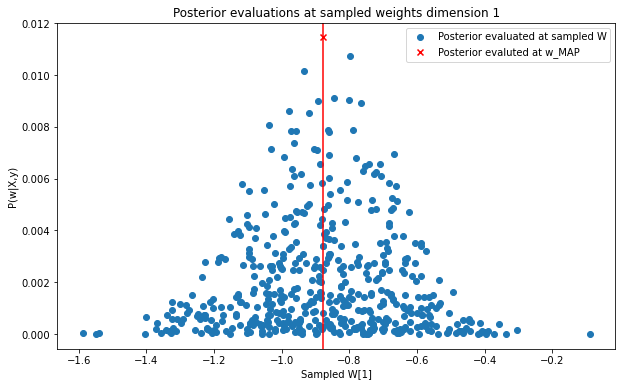

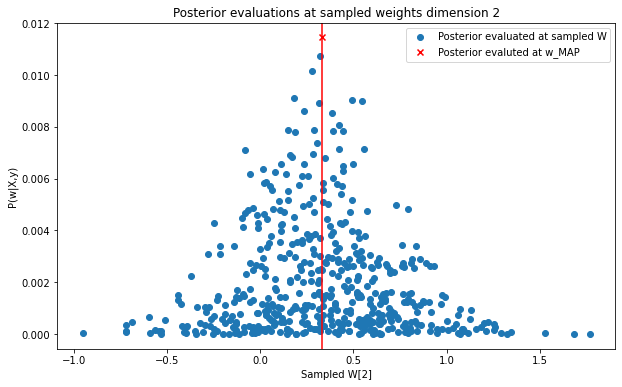

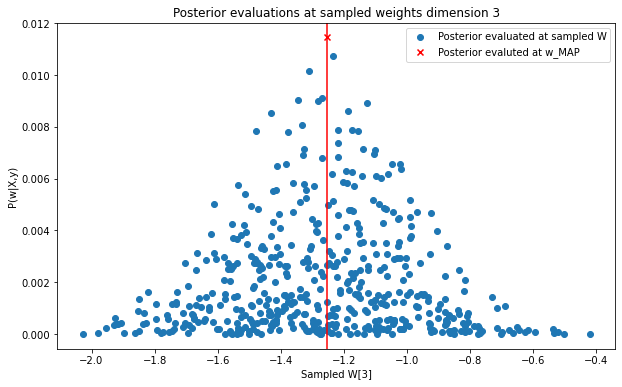

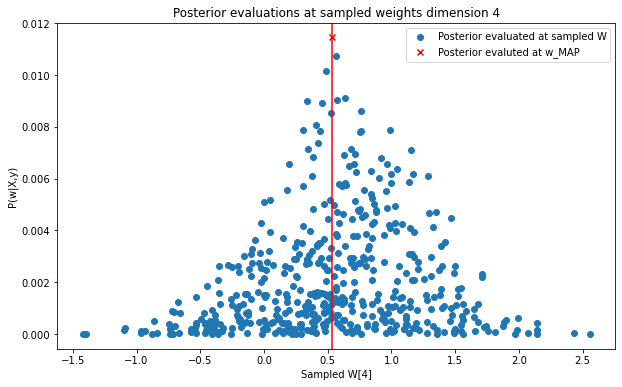

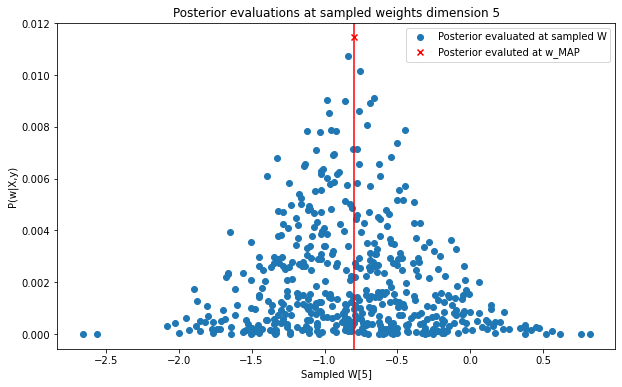

In [10]:
plot_posterior_against_samples(500)

# Q2 Bayesian Linear Model

In [22]:
def features(x):
    """
    evaluates phi(x)
    Inputs:
    x : (N, 1) input datapoints
    Outputs:
    phi : (N, M) features for each datapoint
    """
    year = 0.057 # equal to one year in input space
    phi = np.hstack(
        # add polynomial terms
        [np.power(x, np.arange(11))]
        # add periodic terms:
        + [np.sin(x*2*np.pi*factor/year) for factor in range(1,11)]
        + [np.cos(x*2*np.pi*factor/year) for factor in range(1,11)]
    )
    return phi    

def bayesian_linear_regression():
    # as specified by assignment 
    variance = 1e-3 
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
    x_train = np.vstack((x_train, x_valid))
    y_train = np.vstack((y_train, y_valid))
    # calculate the predictiv posterior mean and variance using Cholesky decomposition 
    phi_train = features(x_train)
    cov_inverse = 1/variance * np.dot(phi_train.T, phi_train) + np.eye(phi_train.shape[1])
    R = cho_factor(cov_inverse)
    mu = 1/variance * cho_solve(R, np.dot(phi_train.T, y_train))
    mu_pred = np.dot(features(x_test), mu)
    # don't compute cov explicitly, just use Cholesky to directly compute cov_pred using the formula 
    cov_pred = np.dot(features(x_test), cho_solve(R, np.transpose(features(x_test)))) + np.eye(x_test.shape[0]) * variance
    # obtain the standard deviation from the covariance matrix 
    std_pred = np.sqrt(np.diag(cov_pred)).reshape((-1,1))
    # plotting 
    plt.figure(figsize=(10, 6))
    plt.plot(x_test, y_test, 'k', label="Test Data", alpha=0.5)
    plt.plot(x_test, mu_pred, 'r', label="Predictive Posterior Mean")
    plt.fill_between(x_test.squeeze(), y1=(mu_pred-3*std_pred).squeeze(), y2=(mu_pred+3*std_pred).squeeze(), color='r', alpha=0.3, label='99.7% Confidence')
    plt.legend(loc=2);
    plt.title('Predictive Posterior Mean and Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('CO2 Level')

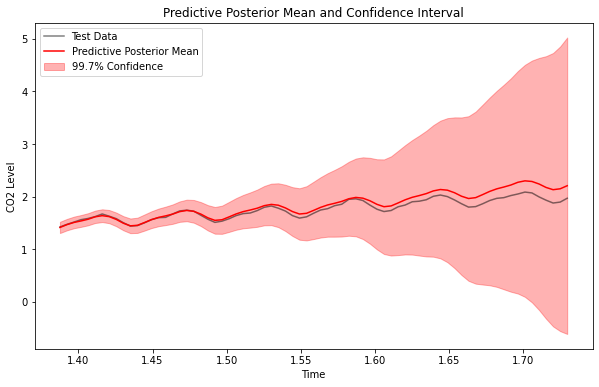

In [23]:
bayesian_linear_regression()